## Preprocessing 

#### if the MR is in dicom 

In [1]:
!python ./preprocessing/dicomtonifti_2.py -i ./data/dicom -o ./data/unprocessed


Looking for DICOM series in: /Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/data/dicom
Error: /Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/data/dicom is not a directory


#### if the MRs are in nifti 

In [2]:
!python ./preprocessing/mri_preprocess_3d_simple.py \
  --temp_img ./preprocessing/atlases/temp_head.nii.gz \
  --input_dir ./data/sample/unprocessed \
  --output_dir ./data/sample/processed

Starting brain MRI preprocessing...

Step 1: Image Registration
Preloading step...
0it [00:00, ?it/s]
Registering images...
0it [00:00, ?it/s]
Successfully registered 0 images.
Contents of output directory ./data/sample/processed/temp_registered:
[]
Registration failed! No images were processed successfully.


## BrainIAC - Feature Extraction

In [3]:
!python get_brainiac_features.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/input_scans.csv \
    --output_csv ./data/output/features.csv \
    --root_dir ./data/sample/processed

BrainIAC Loaded!!
Inference: 100%|███████████████████████████████| 1/1 [00:07<00:00,  7.14s/batch]
Features saved to ./data/output/features.csv


## BrainIAC - Saliency map geneation 

approx. runtime 
-> 12 seconds on CPU
-> 1.5 seconds on GPU (Nvidia A600)

In [4]:
!python get_brainiac_saliencymap.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/input_scans.csv \
    --output_dir ./data/output \
    --root_dir ./data/sample/processed

BrainIAC Loaded!!
Generating saliency maps: 100%|███████████████████| 1/1 [00:17<00:00, 17.52s/it]
Saliency maps generated and saved to ./data/output


### visualize the saliency map 

(128, 128, 128) (128, 128, 128) 1.0 0.001581326825544238


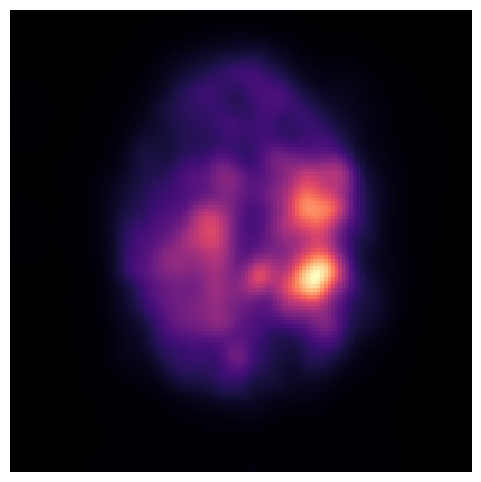

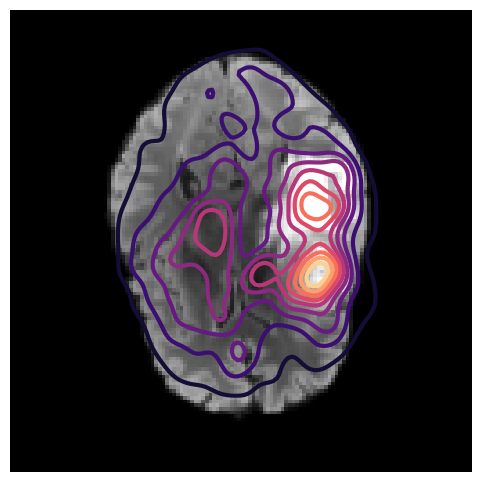

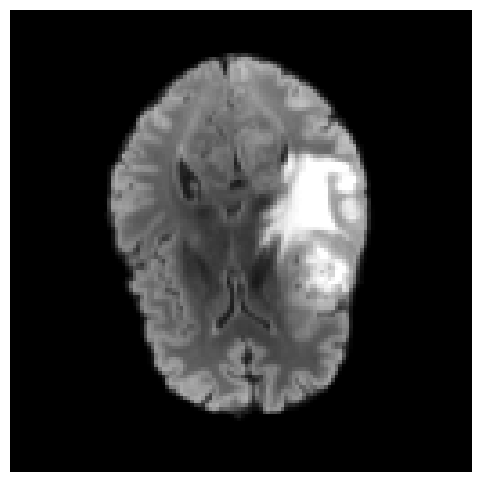

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the NIfTI files
mri_nifti_path = f'./data/output/00001_image.nii.gz' 
saliency_nifti_path = f'./data/output/00001_saliencymap.nii.gz'

mri_img = nib.load(mri_nifti_path)
saliency_img = nib.load(saliency_nifti_path)
mri_data = mri_img.get_fdata()
saliency_data = saliency_img.get_fdata()

print(mri_data.shape, saliency_data.shape, np.max(mri_data), np.max(saliency_data))

# Select a 2D slice based on a index number 
slice_idx = mri_data.shape[2] // 2 
mri_slice = mri_data[:, :, slice_idx]
saliency_slice = saliency_data[:, :, slice_idx]

# Normalize the MRI slice using robust normalization (1st and 99th percentiles)
def normalize_image(img):
    p1, p99 = np.percentile(img, (1, 99))
    img_clipped = np.clip(img, p1, p99)
    img_normalized = (img_clipped - p1) / (p99 - p1)
    return img_normalized

mri_slice_norm = normalize_image(mri_slice)

# Normalization function 
def normalize_saliency(saliency):
    saliency[saliency < 0] = 0
    if np.max(saliency) > 0:
        saliency_normalized = saliency / np.max(saliency)
    else:
        saliency_normalized = saliency
    return saliency_normalized

# Apply Gaussian blur to smooth the saliency map and normalize
saliency_slice_blurred = cv2.GaussianBlur(saliency_slice, (15, 15), 0)
saliency_slice_norm = normalize_saliency(saliency_slice_blurred)

# Apply a threshold to the saliency map
threshold_value = 0.0 
saliency_slice_thresholded = np.where(saliency_slice_norm > threshold_value, saliency_slice_norm, 0)

#  thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(saliency_slice_thresholded.T, cmap='magma', interpolation='none', origin='lower')
plt.axis('off')  

#  MRI slice with contour overlay of the thresholded saliency map
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.contour(saliency_slice_thresholded.T, levels=10, cmap='magma', origin='lower', linewidths=3)  # Adjust the linewidth value as needed
plt.axis('off')  # Remove axis for better visualization


#  MRI slice alone (no overlay)
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice_norm.T, cmap='gray', interpolation='none', origin='lower')
plt.axis('off') 


plt.show()  


## BrainIAC - Feature extraction 

In [6]:
## extract feature vector from the BrainIAC model  

!python get_brainiac_features.py \
    --checkpoint ./checkpoints/BrainIAC.ckpt \
    --input_csv ./data/csvs/input_scans.csv \
    --output_csv ./data/output/features.csv \
    --root_dir ./data/sample/processed

BrainIAC Loaded!!
Inference: 100%|███████████████████████████████| 1/1 [00:07<00:00,  7.18s/batch]
Features saved to ./data/output/features.csv


## Brain age prediction

runtime :
-> 1 second on GPU (Nvidia A6000) for a single scan inference 
-> 2 seconds on CPU for a single scan inference 

In [7]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)


config['data'].update({
    'test_csv': './data/csvs/brainage.csv', 
    'root_dir': './data/sample/processed',
    'collate': 1      # set collate to 1
    
})

config['gpu'].update({
    'visible_device': 'cpu'   # change to cuda:0 if you have a GPU
})

config['infer'].update({
    'checkpoints': './checkpoints/brainage_model_latest.pt'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m Brainage.infer_brainage

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/Brainage/infer_brainage.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/Brainage/infer_brainage.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|██████████████████████

## Sequence classification 

#### Label map

0 - T1w ,
1 - T2w ,
2 - T1CE ,
3 - T2 FLAIR 

In [9]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/sequenceclass.csv', 
    'root_dir': './data/sample/processed',
    'collate': 1      # set collate to 1
       
})

config['infer'].update({
    'checkpoints': './checkpoints/sequenceclassification_model.pt'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m SequenceClassification.infer_sequence

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/SequenceClassification/infer_sequence.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/SequenceClassification/infer_sequence.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inferenc

## IDH Mutation Prediction 

#### label 1 : IDH mutated , label 0 : IDH wild type 

In [ ]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/input_scans.csv', 
    'root_dir': './data/sample/processed',
    'collate': 2   # collate 2 for loading T1ce and FLAIR images      
})

config['infer'].update({
    'checkpoints': './checkpoints/idh_model.76'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m IDHprediction.infer_idh

## Overall Survival 

In [10]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/os.csv', 
    'root_dir': './data/sample/processed' ,
    'collate': 4
})

config['infer'].update({
    'checkpoints': './checkpoints/os_model.pt'
})

# # Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer 1 year overall survival
!python -m OverallSurvival.infer_os

Model and checkpoint loaded!
Inference on test data:   0%|                          | 0/1 [00:00<?, ?batch/s]/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/OverallSurvival/infer_os.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/OverallSurvival/infer_os.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference on test data: 100%|█████

## MCI Classification 

In [14]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/mci.csv', 
    'root_dir': './data/sample/processed' ,
    'collate': 1   
})

config['infer'].update({
    'checkpoints': './checkpoints/mci_model.pt'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m MCIclassification.infer_mci

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/MCIclassification/infer_mci.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/MCIclassification/infer_mci.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|████████████

## Time to stroke 

In [15]:
import yaml

# change the infer csv and model checkpoint in the config 
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

config['data'].update({
    'test_csv': './data/csvs/stroke.csv', 
    'root_dir': './data/sample/processed' ,
    'collate': 1      
})

config['infer'].update({
    'checkpoints': './checkpoints/stroke_model.pt'
})

# Save changes 
with open('./config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

# infer brainage
!python -m timetostroke.infer_stroke

Model and checkpoint loaded!
Inference:   0%|                                       | 0/1 [00:00<?, ?batch/s]/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/timetostroke/infer_stroke.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/brainiac/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/bg6161/Documents/B/BrainIAC/src/BrainIAC/timetostroke/infer_stroke.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)
Inference: 100%|█████████████████